# **TRAINING** **C2TSR** **MODEL USING YOLO V3**



## Step 0: Check if you are able to connect to GPU runtime and view the configuration available

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Mon Aug 17 05:22:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Step 1: Mount Google Drive
Connect to Google drive from Google Colab VM. 
I have created trainC2TSR folder on drive and uploaded the .zip file of image dataset there

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive/trainC2TSR/

generate_train.py  obj.data   obj.zip	  test_on_images.py
latest		   obj.names  testImages  yolov3_custom.cfg


In [ ]:
# this is where my zip is stored (I created a yolov3 folder where I will get my required files from)
!ls /mydrive/trainC2TSR

generate_train.py  obj.data   obj.zip	  test_on_images.py
latest		   obj.names  testImages  yolov3_custom.cfg


### Defining a few utility functions

A few handler functions to interact with Gdrive and local machine

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

## Step 2: Clone Darknet framework
Clone the darknet framework code from AlexeyAB's famous github repository and adjust the Makefile to enable OPENCV and GPU for darknet 

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 14263 (delta 7), reused 12 (delta 6), pack-reused 14240
Receiving objects: 100% (14263/14263), 12.85 MiB | 8.53 MiB/s, done.
Resolving deltas: 100% (9686/9686), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


## Step 3: Build Darknet
Darknet framework is written in C. Hence, we use cmake to build the darknet framework in cloud using updated makefile

In [ ]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

## Step 4: Moving Your Custom Dataset Into Your Cloud VM
The image dataset id ready and arranged in a zip file. So, I can move it into this cloud VM and use it for training.
I renamed the .zip file to obj.zip and then uploaded to my google drive. This actividy reduced the time it takes to transfer our dataset into cloud VM.

In [ ]:
# copy the .zip file into the root directory of cloud VM
#%cd darknet
!cp /mydrive/trainC2TSR/obj.zip ../

In [ ]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../obj.zip -d data/obj

Streaming output truncated to the last 5000 lines.
  inflating: data/obj/FramesBrCr/frame_710_6.txt  
  inflating: data/obj/FramesBrCr/frame_710_8.jpg  
  inflating: data/obj/FramesBrCr/frame_710_8.txt  
  inflating: data/obj/FramesBrCr/frame_711.jpg  
  inflating: data/obj/FramesBrCr/frame_711.txt  
  inflating: data/obj/FramesBrCr/frame_711_2.jpg  
  inflating: data/obj/FramesBrCr/frame_711_2.txt  
  inflating: data/obj/FramesBrCr/frame_711_3.jpg  
  inflating: data/obj/FramesBrCr/frame_711_3.txt  
  inflating: data/obj/FramesBrCr/frame_711_5.jpg  
  inflating: data/obj/FramesBrCr/frame_711_5.txt  
  inflating: data/obj/FramesBrCr/frame_711_6.jpg  
  inflating: data/obj/FramesBrCr/frame_711_6.txt  
  inflating: data/obj/FramesBrCr/frame_711_8.jpg  
  inflating: data/obj/FramesBrCr/frame_711_8.txt  
  inflating: data/obj/FramesBrCr/frame_712.jpg  
  inflating: data/obj/FramesBrCr/frame_712.txt  
  inflating: data/obj/FramesBrCr/frame_712_2.jpg  
  inflating: data/obj/FramesBrCr/frame_

In [ ]:
! mv data/obj/FramesBrCr/* data/obj/
! rm -r data/obj/FramesBrCr

## Step 5: Adjusting configuration files for YOLO v3
This step involves properly configuring the custom .cfg file, obj.data, obj.names and train.txt file. I used Google text editor to edit the files.


#### i) Cfg File
yolov3 configuration file is set as per Cocoa dataset and detecting 80 different classes. Hence, we need to adjust the configuration. So,
copy over the yolov3_custom2.cfg to drive and edit it as per C2TSR model. 

I have commented out this line so as to avoid overriding of the file while training the model for multiple times and updating it every time we train our model.

I have updated following parameters. 

**batch = 64** (this many images+labels are used in the forward pass to compute a gradient and update the weights via backpropagation.)

**subdivisions = 16** The batch is subdivided in this many "blocks". The images of a block are ran in parallel on the gpu.

**max_batches = 114000** (2000*# of classes)

**steps = 91200(80% of max_batches),102000(90% of max_batches)** (Adjust the learning rate after 500 and 1000 batches
scales=0.1,0.2: After 91200, multiply the LR by 0.1, then after 102000 multiply again by 0.2) 

**classes = 57** 

**filters = 186** (# of classes + 5) * 3 - # of convolutional kernels in a layer

Following is the explanation about other parameters:

**decay**: Maybe a term to diminish the weights to avoid having large values. For stability reasons I guess.

**momentum**: I guess the new gradient is computed by momentum * previous_gradient + (1-momentum) * gradient_of_current_batch. Makes the gradient more stable.

**adam**: optimizer

**burn_in**: For the first x batches, slowly increase the learning rate until its final value (your learning_rate parameter value). Use this to decide on a learning rate by monitoring until what value the loss decreases (before it starts to diverge).
**policy**: Use the steps and scales parameters below to adjust the learning rate during training

**angle**: augment image by rotation up to this angle (in degree)
layers

**activation**: Activation function, relu, leaky relu, etc.

**stopbackward**: Do backpropagation until this layer only. Put it in the panultimate convolution layer before the first yolo layer to train only the layers behind that, e.g. when using pretrained weights.

**random**: Put in the yolo layers. If set to 1 do data augmentation by resizing the images to different sizes every few batches. Use to generalize over object sizes. Change random from 1 to 0 to speed up training but slightly reduce accuracy of model. Will also help save memory if you run into any memory issues.


In [ ]:
# download cfg to google drive and change its name. (I have already configured it, so to avoid override of the file I have commented out this line)
#!cp cfg/yolov3.cfg /mydrive/trainC2TSR/yolov3_custom2.cfg

In [ ]:
# upload the custom .cfg back to cloud VM from Google Drive
#%cd darknet
!cp /mydrive/trainC2TSR/yolov3_custom.cfg ./cfg

# upload the custom .cfg back to cloud VM from local machine (uncomment to use)
#%cd cfg
#upload()
#%cd .. 

#### ii) obj.names and obj.data 
**obj.names** is same exactly as classes.txt which gets created during dataset creation step

**obj.data** file contains number of classes accordingly as well as a backup location
This backup path is where we will save the weights of our model throughout training.


In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/trainC2TSR/obj.names ./data
!cp /mydrive/trainC2TSR/obj.data  ./data

# upload the obj.names and obj.data files to cloud VM from local machine (uncomment to use)
#%cd data
#upload()
#%cd .. 

#### iii) Generating train.txt
The train.txt file which hold the relative paths to all our training images.


In [ ]:
# upload the generate_train.py script to cloud VM from Google Drive
!cp /mydrive/trainC2TSR/generate_train.py ./

# upload the generate_train.py script to cloud VM from local machine (uncomment to use)
#upload()


In [ ]:
!python generate_train.py

In [ ]:
# verify train.txt can be seen in our darknet/data folder
!ls data/

9k.tree     eagle.jpg	 imagenet.labels.list	   obj.data	     scream.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  obj.names	     train.txt
coco.names  goal.txt	 labels			   openimages.names  voc.names
dog.jpg     horses.jpg	 obj			   person.jpg


## Step 6: Download pre-trained weights for the convolutional layers.
This step downloads the weights for the convolutional layers of the YOLOv3 network. We don't necessarily need to use these weights but by using these weights helps the custom object detector to be way more accurate and not have to train as long.

In [ ]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

## Step 7: Train Your Custom Object Detector!
Now in this step, we will train our C2TSR traffic signs and signals  detector with 57 different classes by running the following command. (dont_show flag stops a chart from popping up since cloud can't open images on the spot)
```
!./darknet detector train <path to obj.data> <path to custom config> darknet53.conv.74 -dont_show
```


In [ ]:
# train your custom detector
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show


Following command shows a chart of your average loss vs. iterations. For your model to be 'accurate' you would aim for a loss under 2.

In [ ]:
imShow('chart.png')

Every 100 iterations a weights file called **yolov3_custom_last.weights** is saved to mydrive/trainC2TSR/backup/ folder (wherever your backup folder is). So, in case of runtime crashes, we can use this last weights and resume training our model
```
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show
```

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/trainC2TSR/latest/yolov3_custom_last.weights -dont_show

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
yolov3_custom
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 1

[Errno 20] Not a directory: 'darknet'
/content/darknet


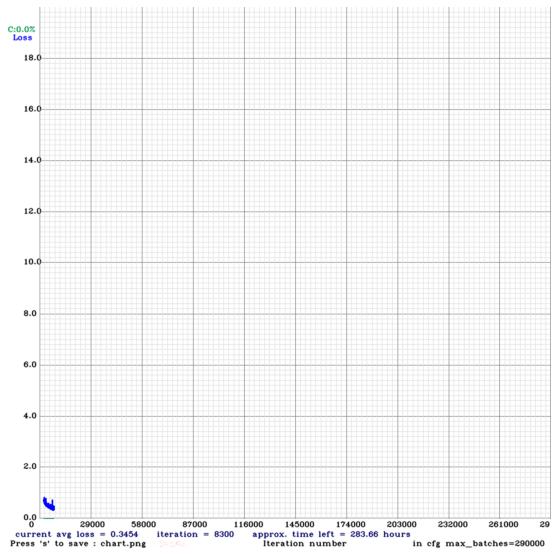

In [ ]:

imShow('chart.png')

In [ ]:
%cd darknet
!./darknet detector test /mydrive/trainC2TSR/obj.data /mydrive/trainC2TSR/yolov3_custom.cfg /mydrive/trainC2TSR/backup/yolov3_custom_6000.weights /mydrive/trainC2TSR/testImages/download\ \(1\).png

/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Couldn't open file: data/obj.names


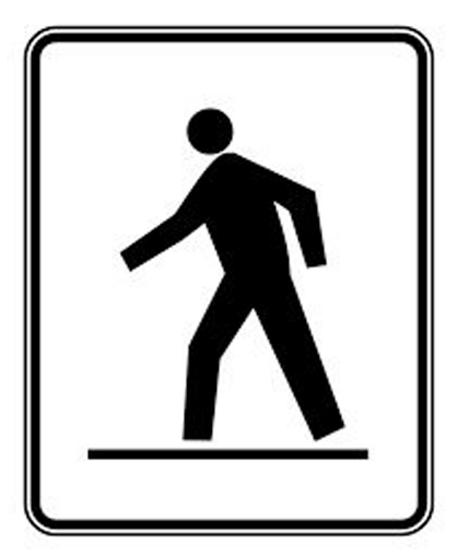

In [ ]:
imShow('predictions.jpg')

In [ ]:
download('predictions.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>